In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import seaborn as sns
import re

### Data Collection

In [3]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module5_exercise_train.csv')
download_file(test_data_url, 'module5_exercise_test.csv')

Downloaded module5_exercise_train.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_train.csv
Downloaded module5_exercise_test.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_test.csv


In [4]:
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")
df_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

df_train.head()

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
0,2015-01-08,Cloudy,69.304377,27.74 km/h,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661,273.511353
1,2015-01-09,Sunny,55.955975,21.78 km/h,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365,258.827085
2,2015-01-10,Rainy,62.701614,6.83 m/s,Moderate,-2.603544,-2.422001,-3.685819,-2.392354,-1.936704,-2.950332,-3.074828,-2.698650,-2.354860,-2.770883,302.535033
3,2015-01-11,Snowy,60.375001,5.79 m/s,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN,296.270989
4,2015-01-12,Snowy,NaN,25.14 km/h,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098,323.498090


### Data analysis

In [5]:
#### Make a complete analysis on data preprocessing
# Inconsistencies
print(df_train['wind_speed'].unique()[:20]) 



bad_cols = {}
for c in df_train.columns:
    types = df_train[c].apply(type).unique()
    if len(types) > 1:
        bad_cols[c] = types

if bad_cols:
    print("Colonnes avec incohérences de type :")
    for col, t in bad_cols.items():
        print(f"{col} → {t}")
else:
    print("Toutes les colonnes sont homogènes")

    
# Feature Selection and/or Dimensionality Reduction

['27.74 km/h' '21.78 km/h' '6.83 m/s' '5.79 m/s' '25.14 km/h' '28.75 km/h'
 '19.97 km/h' '4.27 m/s' '23.63 km/h' '20.10 km/h' '15.79 km/h' '6.08 m/s'
 '5.22 m/s' nan '25.82 km/h' '7.25 m/s' '18.95 km/h' '5.18 m/s' '5.43 m/s'
 '4.12 m/s']
Colonnes avec incohérences de type :
weather_condition → [<class 'str'> <class 'float'>]
wind_speed → [<class 'str'> <class 'float'>]


In [6]:
# Duplicates (data.duplicated().sum())

exact_duplicates = df_train[df_train.duplicated()]
print("Exact duplicates:")
print(exact_duplicates)

Exact duplicates:
            date weather_condition   humidity  wind_speed  \
6     2015-01-13            Cloudy  58.649834  28.75 km/h   
52    2015-02-27             Snowy  61.321278  11.61 km/h   
59    2015-03-05            Cloudy  54.187891    1.02 m/s   
129   2015-05-13             Rainy  73.325559    0.00 m/s   
141   2015-05-24            Cloudy  62.308585   9.01 km/h   
...          ...               ...        ...         ...   
1838  2019-10-26             Sunny  53.952131    4.30 m/s   
1875  2019-12-01             Snowy  72.532746    3.99 m/s   
1886  2019-12-11               NaN  61.201308  27.61 km/h   
1893  2019-12-17             Snowy  65.362283    5.21 m/s   
1906  2019-12-29             Rainy  68.085227    7.24 m/s   

     oil_brent_price_indicator  temperature_station1  temperature_station2  \
6                         High             -5.037719             -4.891658   
52                    Moderate             -0.765329             -1.089098   
59             

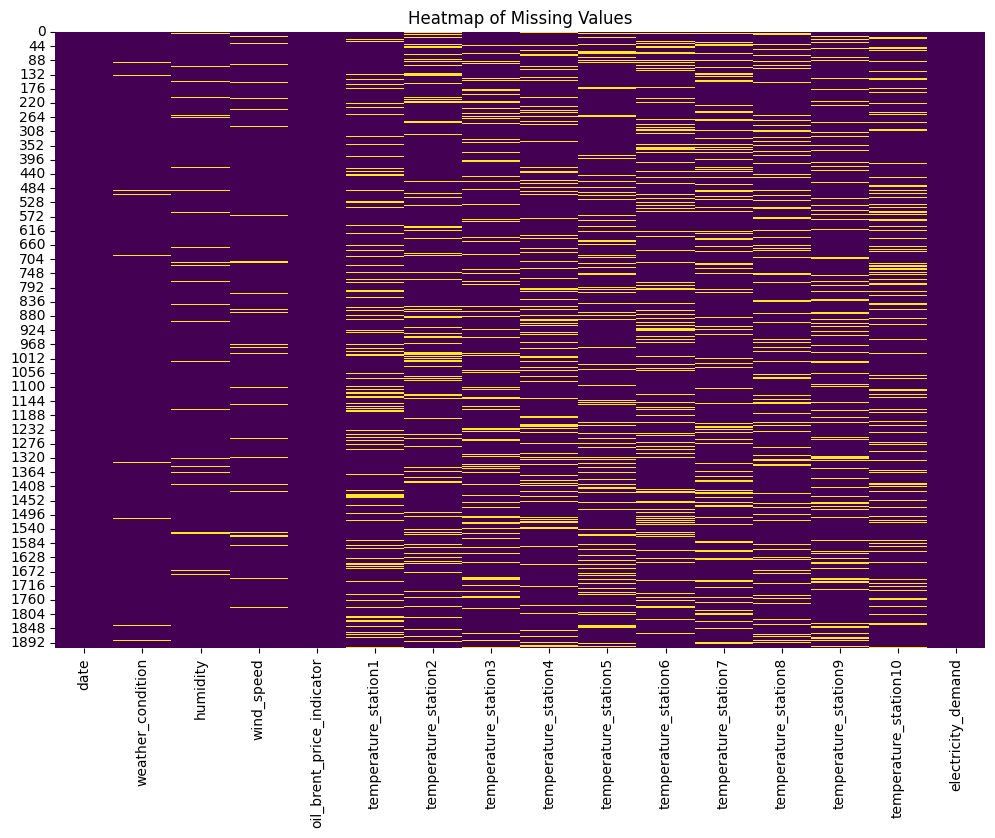

In [7]:
# Missing values (data.isnull().sum())
plt.figure(figsize=(12, 8))
sns.heatmap(df_train.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()

In [8]:
# Categorical
print("Data types:")
print(df_train.dtypes)
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns
print("Colonnes catégorielles :", list(cat_cols))


Data types:
date                          object
weather_condition             object
humidity                     float64
wind_speed                    object
oil_brent_price_indicator     object
temperature_station1         float64
temperature_station2         float64
temperature_station3         float64
temperature_station4         float64
temperature_station5         float64
temperature_station6         float64
temperature_station7         float64
temperature_station8         float64
temperature_station9         float64
temperature_station10        float64
electricity_demand           float64
dtype: object
Colonnes catégorielles : ['date', 'weather_condition', 'wind_speed', 'oil_brent_price_indicator']


In [9]:
# Outliers
import numpy as np
from scipy import stats

def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    return data[z_scores > threshold]


for col, ty in df_train.dtypes.items():
    if ty == "float64":
        outliers = detect_outliers_zscore(df_train[col])
        if not outliers.empty:
            print(f"Outliers dans {col}:")
            print(outliers)
                

Outliers dans electricity_demand:
1029   -223288.771683
Name: electricity_demand, dtype: float64


Feature Engineering  -> On a la date, classiquement on cherche à l'exprimer en min/heure/jour/mois/anné mais il ne faut pas oublier que ces valeurs sont cycliques, 23h est proche de 01h mais 23 est loin de 1 il faudra docn projetter les valeurs sur des fonctions cycliques comme le sin et le cos 

de plus on a des valeurs qui se combinent, humidity, temperature etc il faudrait les regrouper comme dans le cours. 

En définitive de multitude de choses sont possible dans ce domaine le tout est de comprendre ce sur quoi on travail, c'est la partie réflexion. 

Feature Selection and/or Dimensionality Reduction -> 

In [10]:
data = pd.concat([df_train, df_test], axis=0)

In [11]:
df_train.shape

(1909, 16)

In [12]:
df_test.shape

(365, 15)

In [13]:
def plot_feature_over_time(df, feature, date_id_start, date_id_end):
    df_filtered = df[(df['date'] >= date_id_start) & (df['date'] <= date_id_end)]
    
    if feature not in df_filtered.columns:
        print(f"Feature '{feature}' not found in the DataFrame.")
        return
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['date'], df_filtered[feature], label=feature, linestyle='-')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'{feature} from {date_id_start} to {date_id_end}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [14]:
data['date'] = pd.to_datetime(data['date'])

In [15]:
data

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
0,2015-01-08,Cloudy,69.304377,27.74 km/h,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661,273.511353
1,2015-01-09,Sunny,55.955975,21.78 km/h,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365,258.827085
2,2015-01-10,Rainy,62.701614,6.83 m/s,Moderate,-2.603544,-2.422001,-3.685819,-2.392354,-1.936704,-2.950332,-3.074828,-2.698650,-2.354860,-2.770883,302.535033
3,2015-01-11,Snowy,60.375001,5.79 m/s,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN,296.270989
4,2015-01-12,Snowy,NaN,25.14 km/h,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098,323.498090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,Snowy,71.521673,22.78 km/h,Moderate,-1.674798,-2.338987,-1.829170,-0.881428,-0.571347,-2.231680,-1.962735,-1.602805,-1.264779,-1.705180,NaN
361,2019-12-28,Sunny,67.220123,18.33 km/h,High,3.209205,2.508606,2.195577,NaN,NaN,3.236547,3.181473,3.094390,NaN,3.475638,NaN
362,2019-12-29,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333,NaN
363,2019-12-30,Cloudy,65.877214,7.67 m/s,Moderate,NaN,0.700484,NaN,-0.407440,-0.580917,-0.444730,0.034229,0.021199,-0.864657,NaN,NaN


In [16]:
def parse_wind_speed(val):
        if pd.isna(val):
            return np.nan
        # détecter si c'est en m/s
        if "m/s" in val:
            return float(re.sub("[^0-9.]", "", val)) * 3.6  # conversion en km/h
        elif "km/h" in val:
            return float(re.sub("[^0-9.]", "", val))
        else:
            return np.nan  # valeur inconnue

data['wind_speed'] = data['wind_speed'].apply(parse_wind_speed)
data['wind_speed']

0      27.740
1      21.780
2      24.588
3      20.844
4      25.140
        ...  
360    22.780
361    18.330
362    26.064
363    27.612
364    30.990
Name: wind_speed, Length: 2274, dtype: float64

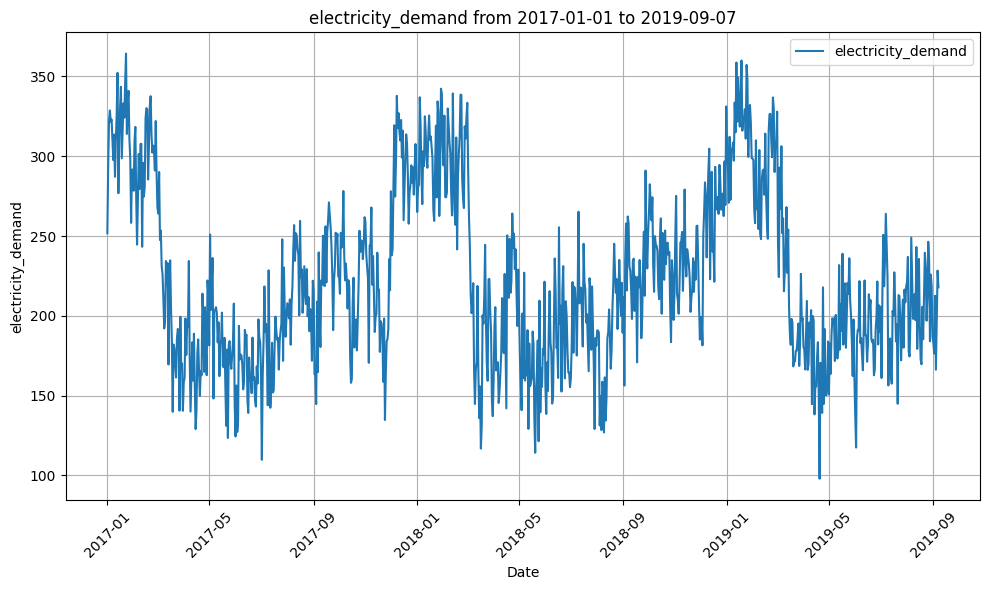

In [17]:
Q1 = data['electricity_demand'].quantile(0.25)
Q3 = data['electricity_demand'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['electricity_demand'] >= Q1 - 1.5*IQR) & (data['electricity_demand'] <= Q3 + 1.5*IQR)]


plot_feature_over_time(data, 'electricity_demand', '2017-01-01', '2019-09-07')

/tmp/ipykernel_44731/3943963703.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['humidity'] = data['humidity'].interpolate()


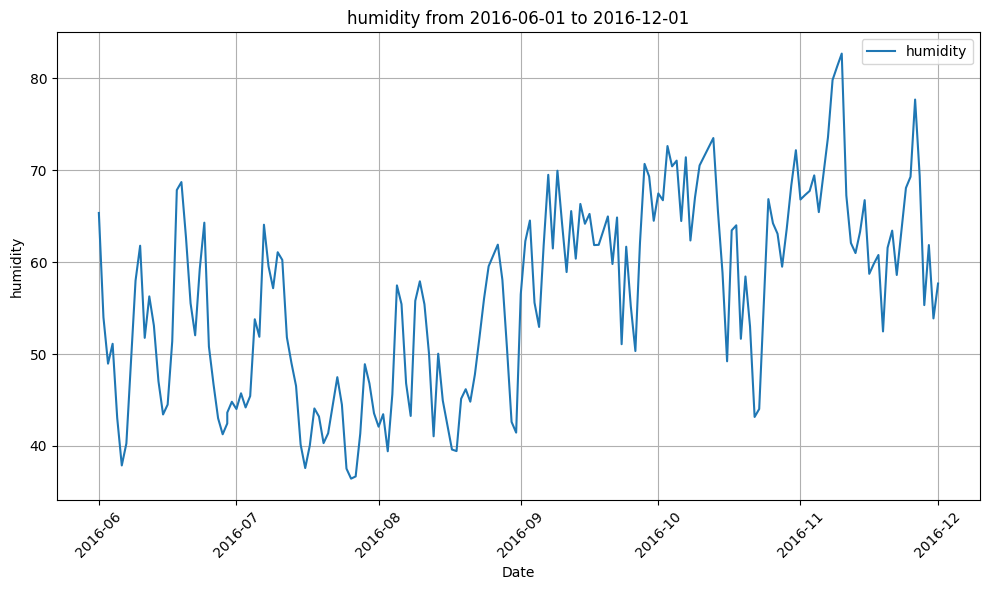

In [18]:
data['humidity'] = data['humidity'].interpolate()

plot_feature_over_time(data, 'humidity', '2016-06-01', '2016-12-01')

### Data Preprocessing Evaluation Strategy

In [19]:
# Provide a complete data preprocessing transformations

In [20]:
# 1. Handle Inconsistencies
def handle_inconsistencies(X_train, y_train, X_val=None):
    def handle(X_train):
        X_train['weather_condition'] = X_train['weather_condition'].astype(str)
        X_train['weather_condition'] = X_train['weather_condition'].replace(
        ['nan', 'NaN', 'None', 'NULL', 'null', 'NA', 'n/a'], 
        np.nan)



        def parse_wind_speed(val):
            if pd.isna(val):
                return np.nan
            # détecter si c'est en m/s
            if "m/s" in val:
                return float(re.sub("[^0-9.]", "", val)) * 3.6  # conversion en km/h
            elif "km/h" in val:
                return float(re.sub("[^0-9.]", "", val))
            else:
                return np.nan  # valeur inconnue
            
        X_train['wind_speed'] = X_train['wind_speed'].apply(parse_wind_speed)
        return X_train
    
    X_train = handle(X_train)
    
    if X_val is not None:
        X_val = handle(X_val)
        return X_train.copy(), y_train, X_val.copy()
    else:
        return X_train.copy(), y_train

# 2. Handling Duplicates
def handle_duplicates(X_train, y_train, X_val=None):
    if X_val is not None:
        X_train_no_duplicates = X_train.drop_duplicates()
        y_train_no_duplicates = y_train.loc[X_train_no_duplicates.index]
        X_val_no_duplicates = X_val.drop_duplicates()
        return X_train.copy(), y_train, X_val.copy()
    else:
        X_train_no_duplicates = X_train.drop_duplicates()
        y_train_no_duplicates = y_train.loc[X_train_no_duplicates.index]
        return X_train_no_duplicates, y_train_no_duplicates

# 3. Handling Missing Values
def handle_missing_values(X_train, y_train, X_val=None):

    
    if X_val is not None:
        X_train['humidity'] = X_train['humidity'].interpolate()
        X_val['humidity'] = X_val['humidity'].interpolate()
        X_train = X_train.fillna(-1)
        X_val = X_val.fillna(-1)
        return X_train.copy(), X_val.copy()
    else:
        X_train = X_train.fillna(-1)
        X_train['humidity'] = X_train['humidity'].interpolate()
        return X_train

# 4. Handling Categorical Values
def handle_categorical(X_train, y_train, X_val=None):
    categories = ["sunny", "cloudy", "rainy", "storm"]
    X_train['weather_condition'] = (
    X_train['weather_condition']
    .astype(str)
    .str.strip()
    .str.lower()
    .replace(['nan','na','none','null','n/a','?',''], np.nan))

    X_train['weather_condition'] = pd.Categorical(
        X_train['weather_condition'],
        categories=categories,
        ordered=True)

    X_train['weather_condition_enc'] = X_train['weather_condition'].cat.codes

    if X_val is not None:
        X_val['weather_condition'] = (
        X_val['weather_condition']
        .astype(str)
        .str.strip()
        .str.lower()
        .replace(['nan','na','none','null','n/a','?',''], np.nan))

        X_val['weather_condition'] = pd.Categorical(
            X_val['weather_condition'],
            categories=categories,
            ordered=True)

        X_val['weather_condition_enc'] = X_val['weather_condition'].cat.codes
        return X_train.copy(), X_val.copy()
    else:
        return X_train.copy()

# 5. Handling Outliers
def handle_outliers(X_train, y_train, X_val=None):
    
    if X_val is not None:
        return X_train.copy(), y_train, X_val.copy()
    else:
        return X_train.copy(), y_train

# 6. Feature Engineering
def feature_engineering(X_train, y_train, X_val=None):
    def add_new_feature(X_train):
        X_train['date'] = pd.to_datetime(X_train['date'])
        X_train['year'] = X_train['date'].dt.year
        X_train['month'] = X_train['date'].dt.month
        X_train['day'] = X_train['date'].dt.day
        X_train['hour'] = X_train['date'].dt.hour
        X_train['dayofweek'] = X_train['date'].dt.dayofweek
        X_train['is_weekend'] = X_train['dayofweek'].isin([5, 6]).astype(int)

        # make it cyclical

        X_train['hour_sin'] = np.sin(2 * np.pi * X_train['hour']/24)
        X_train['hour_cos'] = np.cos(2 * np.pi * X_train['hour']/24)

        # Day of week (7-day cycle)
        X_train['dow_sin'] = np.sin(2 * np.pi * X_train['dayofweek']/7)
        X_train['dow_cos'] = np.cos(2 * np.pi * X_train['dayofweek']/7)

        # Month (12-month cycle)
        X_train['month_sin'] = np.sin(2 * np.pi * X_train['month']/12)
        X_train['month_cos'] = np.cos(2 * np.pi * X_train['month']/12)

        X_train['temperature'] = X_train['temperature_station1']

        for i in range(2, 11):
            X_train['temperature'] = X_train[f'temperature_station{i}']

        X_train['temperature_feel'] = X_train['temperature'] - 0.55 * (1 - X_train['humidity'] / 100) * (X_train['temperature'] - 14.5)
        # X_train['log_windspeed'] = np.log1p(X_train['wind_speed'])
        return X_train

    X_train = add_new_feature(X_train)

    if X_val is not None:
        X_val = add_new_feature(X_val)
        return X_train.copy(), y_train, X_val.copy()
    else:
        return X_train.copy(), y_train

# 7. Feature Selection and Dimensionality Reduction
def feature_selection(X_train, y_train, X_val=None):
    selected_columns = ['humidity', 'temperature_station1',
       'temperature_station2', 'temperature_station3', 'temperature_station4',
       'temperature_station5', 'temperature_station6', 'temperature_station7',
       'temperature_station8', 'temperature_station9', 'temperature_station10', 
       'temperature_feel',  'dow_sin', 'dow_cos', 'hour_sin', 'hour_cos', 
        'month_sin', 'month_cos', 'hour', 'day', 'year', 'dayofweek', 'is_weekend', 
        'weather_condition_enc', 
        #'log_windspeed'
        ]
    if X_val is not None:
        return X_train[selected_columns], X_val[selected_columns]
    else:
        return X_train[selected_columns]

In [21]:
def evaluate_pipeline(X, y, n_splits=5):

    # X_origin = X.copy()
    # Y_origin = y.copy()

    ### call transformations here, if there is no learning and no need to be crossval
    # X, y = handle_inconsistencies(X, y)
    # X, y = handle_duplicates(X, y)
    # X  = handle_missing_values(X, y)
    # X = handle_categorical(X, y)
    # X, y = handle_outliers(X, y)
    # X, y = feature_engineering(X, y)
    # X = feature_selection(X, y)
    
    model = LinearRegression()
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    train_scores = []
    val_scores = []
    
    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"Processing fold {fold + 1}/{n_splits}...")
        # X = X_origin.copy() 
        # y = Y_origin.copy()
        
        # Split data into train and validation sets
        X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
        y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

        ### call transformations here, if there is learning
        X_train, y_train, X_val = handle_inconsistencies(X_train, y_train, X_val)
        X_train, y_train, X_val = handle_duplicates(X_train, y_train, X_val)
        X_train, X_val = handle_missing_values(X_train, y_train, X_val)
        X_train, X_val = handle_categorical(X_train, y_train, X_val)
        X_train, y_train, X_val = handle_outliers(X_train, y_train, X_val)
        X_train, y_train, X_val = feature_engineering(X_train, y_train, X_val)
        X_train, X_val = feature_selection(X_train, y_train, X_val)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on training set
        y_train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_scores.append(train_mse)
        
        # Predict on validation set
        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_scores.append(val_mse)
        
        print(f"Fold {fold + 1} Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")
    
    # Compute mean, max, and min values for train and validation MSE
    mean_train_mse = np.mean(train_scores)
    max_train_mse = np.max(train_scores)
    min_train_mse = np.min(train_scores)
    
    mean_val_mse = np.mean(val_scores)
    max_val_mse = np.max(val_scores)
    min_val_mse = np.min(val_scores)
    
    # Print results
    print("\nTrain MSE:")
    print(f"Mean: {mean_train_mse:.4f}, Max: {max_train_mse:.4f}, Min: {min_train_mse:.4f}")
    
    print("\nValidation MSE:")
    print(f"Mean: {mean_val_mse:.4f}, Max: {max_val_mse:.4f}, Min: {min_val_mse:.4f}")
    
    return mean_val_mse  # Return mean validation MSE as the overall score

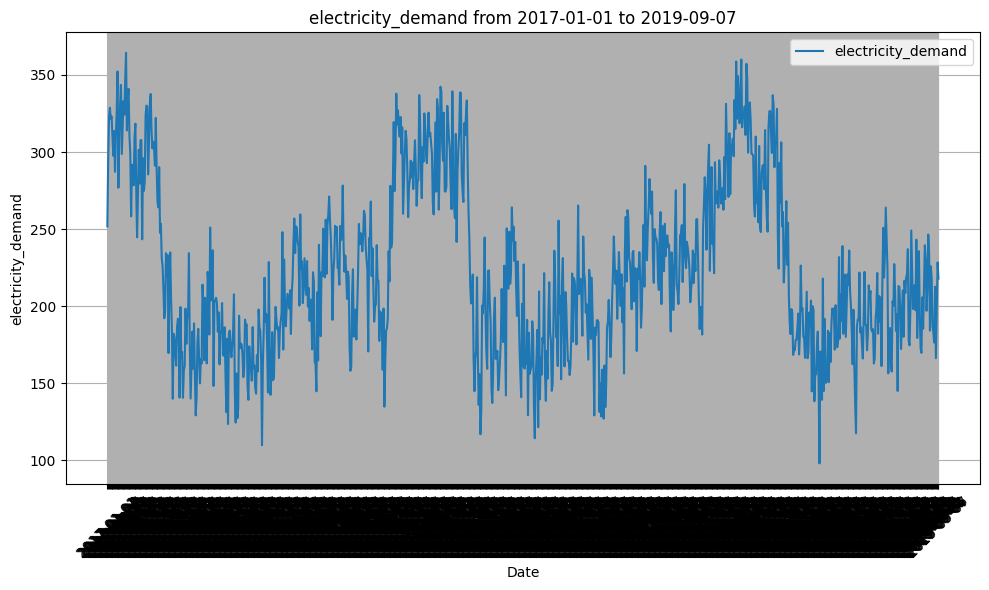

Processing fold 1/5...
Fold 1 Train MSE: 947.5088, Validation MSE: 1464.6830
Processing fold 2/5...
Fold 2 Train MSE: 1093.6206, Validation MSE: 1169.4037
Processing fold 3/5...
Fold 3 Train MSE: 1067.1943, Validation MSE: 922369.1571
Processing fold 4/5...
Fold 4 Train MSE: 1228.2863, Validation MSE: 1462.8407
Processing fold 5/5...
Fold 5 Train MSE: 1201.8166, Validation MSE: 1268.9269

Train MSE:
Mean: 1107.6853, Max: 1228.2863, Min: 947.5088

Validation MSE:
Mean: 185547.0023, Max: 922369.1571, Min: 1169.4037


np.float64(185547.00226670472)

In [28]:
# Préparer X et y

Q1 = df_train['electricity_demand'].quantile(0.25)
Q3 = df_train['electricity_demand'].quantile(0.75)
IQR = Q3 - Q1
df_train = df_train[(df_train['electricity_demand'] >= Q1 - 1.5*IQR) & (df_train['electricity_demand'] <= Q3 + 1.5*IQR)]
plot_feature_over_time(df_train, 'electricity_demand', '2017-01-01', '2019-09-07')

df_train['humidity'] = df_train['humidity'].interpolate()
df_train['date'] = pd.to_datetime(df_train['date'])

X = df_train.drop(columns=['electricity_demand'])
y = df_train['electricity_demand']


# Lancer l’évaluation

evaluate_pipeline(X, y)


### Generating Submission File

In [29]:
# Train and submit your results

In [30]:
# Prepare X_train and y_train from your data
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")

X_train = df_train.drop(columns=['electricity_demand'], axis=1)
y_train = df_train['electricity_demand']

X_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

In [31]:
def train_and_predict_to_submit(X_train, y_train, X_test):
    model = LinearRegression()
    
    X_train, y_train, X_test = handle_inconsistencies(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_duplicates(X_train, y_train, X_test)
    X_train, X_test = handle_missing_values(X_train, y_train, X_test)
    X_train, X_test = handle_categorical(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_outliers(X_train, y_train, X_test)
    X_train, y_train, X_test = feature_engineering(X_train, y_train, X_test)
    X_train, X_test = feature_selection(X_train, y_train, X_test)

    # Train the model on the entire training set
    print(f"Training model on entire dataset of shape: {X_train.shape}")
    model.fit(X_train, y_train)
    
    # Predict on the test set
    print(f"Predicting on test dataset of shape: {X_test.shape}")
    y_test_pred = model.predict(X_test)
    
    return y_test_pred

In [32]:
# Call serve_model to train and predict
y_test_pred = train_and_predict_to_submit(X_train, y_train, X_test)

Training model on entire dataset of shape: (1909, 24)
Predicting on test dataset of shape: (365, 24)


In [33]:
# Generating Submission File
submission = pd.DataFrame({
    'date': X_test['date'],
    'electricity_demand': y_test_pred
})

# Save the submission file
submission.to_csv('submission.csv', index=False, sep=',')
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.


Malgré le prétraitement, je n’ai pas réussi à obtenir une MSE satisfaisante. Je suis désolé, mais je ne peux pas faire mieux dans le temps imparti.